**Секція 1. Логістична регресія з нуля.**

Будемо крок за кроком будувати модель лог регресії з нуля для передбачення, чи буде врожай більше за 80 яблук (задача подібна до лекційної, але на класифікацію).

Давайте нагадаємо основні формули для логістичної регресії.

### Функція гіпотези - обчислення передбачення у логістичній регресії:

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

Де:
- $ \hat{y} $ — це ймовірність "позитивного" класу.
- $ x $ — це вектор (або матриця для набору прикладів) вхідних даних.
- $ W $ — це вектор (або матриця) вагових коефіцієнтів моделі.
- $ b $ — це зміщення (bias).
- $ \sigma(z) $ — це сигмоїдна функція активації.

### Як обчислюється сигмоїдна функція:

Сигмоїдна функція $ \sigma(z) $ має вигляд:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Ця функція перетворює будь-яке дійсне значення $ z $ в інтервал від 0 до 1, що дозволяє інтерпретувати вихід як ймовірність для логістичної регресії.

### Формула функції втрат для логістичної регресії (бінарна крос-ентропія):

Функція втрат крос-ентропії оцінює, наскільки добре модель передбачає класи, порівнюючи передбачені ймовірності $ \hat{y} $ із справжніми мітками $ y $. Формула наступна:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

Де:
- $ y $ — це справжнє значення (мітка класу, 0 або 1).
- $ \hat{y} $ — це передбачене значення (ймовірність).



1.
Тут вже наведений код для ініціювання набору даних в форматі numpy. Перетворіть `inputs`, `targets` на `torch` тензори. Виведіть результат на екран.

In [202]:
import torch
import numpy as np

In [203]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

In [204]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [205]:
inputs, targets

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.]]),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

2. Ініціюйте ваги `w`, `b` для моделі логістичної регресії потрібної форми зважаючи на розмірності даних випадковими значеннями з нормального розподілу. Лишаю тут код для фіксації `random_seed`.

In [206]:
torch.random.manual_seed(1)

In [207]:
n_features = inputs.shape[1]

In [208]:
w = torch.randn(1, n_features, requires_grad=True)
b = torch.randn(1, requires_grad=True)

In [209]:
w, b

(tensor([[0.66135, 0.26692, 0.06168]], requires_grad=True),
 tensor([0.62132], requires_grad=True))

3. Напишіть функцію `model`, яка буде обчислювати функцію гіпотези в логістичній регресії і дозволяти робити передбачення на основі введеного рядка даних і коефіцієнтів в змінних `w`, `b`.

  **Важливий момент**, що функція `model` робить обчислення на `torch.tensors`, тож для математичних обчислень використовуємо фукнціонал `torch`, наприклад:
  - обчсилення $e^x$: `torch.exp(x)`
  - обчсилення $log(x)$: `torch.log(x)`
  - обчислення середнього значення вектору `x`: `torch.mean(x)`

  Використайте функцію `model` для обчислення передбачень з поточними значеннями `w`, `b`.Виведіть результат обчислень на екран.

  Проаналізуйте передбачення. Чи не викликають вони у вас підозр? І якщо викликають, то чим це може бути зумовлено?

In [210]:
def model(data, w, b):
  preds = 1 / (1 + torch.exp(-(data @ w.t() + b)))
  return preds

In [211]:
model_preds = model(inputs, w, b)
targets, model_preds

(tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], grad_fn=<MulBackward0>))

В передбаченнях ми отримали всі значення = 1. Це і є підозрілим. Це можу бути зумовлено тим, що ознаки у нас мають доволі великі числа (від 37 до 134), плюс ваги так само великі. В результаті ми отримуємо e в ступіні - велике число, що в свою чергу дає результат, що прагне до 0. Тому 1 / 1 + 0 = 1

4. Напишіть функцію `binary_cross_entropy`, яка приймає на вхід передбачення моделі `predicted_probs` та справжні мітки в даних `true_labels` і обчислює значення втрат (loss)  за формулою бінарної крос-ентропії для кожного екземпляра та вертає середні втрати по всьому набору даних.
  Використайте функцію `binary_cross_entropy` для обчислення втрат для поточних передбачень моделі.

In [212]:
def binary_cross_entropy(predicted_probs, true_labels):
  p = predicted_probs.squeeze().to(torch.float32)
  y = true_labels.squeeze().to(torch.float32)
  loss = (-(y * torch.log(p) + (1 - y) * torch.log(1 - p))).mean()

  return loss



In [213]:
loss = binary_cross_entropy(model_preds, targets)
loss

tensor(nan, grad_fn=<MeanBackward0>)

Я перероблювала декілька раз свої функції але все одно отримую loss = nan. І це ніби як логічно, бо у мене всі пробабілітіс вийшли 1 і в цьому виразі torch.log(1 - p) я отримую log(0) - яке неможливе. Але виходячи з наведеного нижче пояснення, після backpropagation я б мала отримати якість мізерні але значення, а я отримую nan. То ж я йду далі, бо так можна застрягнути на цьому навічно.

5. Зробіть зворотнє поширення помилки і виведіть градієнти за параметрами `w`, `b`. Проаналізуйте їх значення. Як гадаєте, чому вони саме такі?

In [214]:
loss.backward()

In [215]:
print(w)
print(w.grad)

tensor([[0.66135, 0.26692, 0.06168]], requires_grad=True)
tensor([[nan, nan, nan]])


In [216]:
print(b)
print(b.grad)

tensor([0.62132], requires_grad=True)
tensor([nan])


**Що сталось?**

В цій задачі, коли ми ініціювали значення випадковими значеннями з нормального розподілу, насправді ці значення не були дуже гарними стартовими значеннями і привели до того, що градієнти стали дуже малими або навіть рівними нулю (це призводить до того, що градієнти "зникають"), і відповідно при оновленні ваг у нас не буде нічого змінюватись. Це називається `gradient vanishing`. Це відбувається через **насичення сигмоїдної функції активації.**

У нашій задачі ми використовуємо сигмоїдну функцію активації, яка має такий вигляд:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$


Коли значення $z$ дуже велике або дуже мале, сигмоїдна функція починає "насичуватись". Це означає, що для великих позитивних $z$ сигмоїда наближається до 1, а для великих негативних — до 0. В цих діапазонах градієнти починають стрімко зменшуватись і наближаються до нуля (бо градієнт - це похідна, похідна на проміжку функції, де вона паралельна осі ОХ, дорівнює 0), що робить оновлення ваг неможливим.

![](https://editor.analyticsvidhya.com/uploads/27889vaegp.png)

У логістичній регресії $ z = x \cdot w + b $. Якщо ваги $w, b$ - великі, значення $z$ також буде великим, і сигмоїда перейде в насичену область, де градієнти дуже малі.

Саме це сталося в нашій задачі, де великі випадкові значення ваг викликали насичення сигмоїдної функції. Це в свою чергу призводить до того, що під час зворотного поширення помилки (backpropagation) модель оновлює ваги дуже повільно або зовсім не оновлює. Це називається проблемою **зникнення градієнтів** (gradient vanishing problem).

**Що ж робити?**
Ініціювати ваги маленькими значеннями навколо нуля. Наприклад ми можемо просто в існуючій ініціалізації ваги розділити на 1000. Можна також використати інший спосіб ініціалізації вагів - інформація про це [тут](https://www.geeksforgeeks.org/initialize-weights-in-pytorch/).

Як це робити - показую нижче. **Виконайте код та знову обчисліть передбачення, лосс і виведіть градієнти.**

А я пишу пояснення, чому просто не зробити

```
w = torch.randn(1, 3, requires_grad=True)/1000
b = torch.randn(1, requires_grad=True)/1000
```

Нам потрібно, аби тензори вагів були листовими (leaf tensors).

1. **Що таке листовий тензор**
Листовий тензор — це тензор, який був створений користувачем безпосередньо і з якого починається обчислювальний граф. Якщо такий тензор має `requires_grad=True`, PyTorch буде відслідковувати всі операції, виконані над ним, щоб правильно обчислювати градієнти під час навчання.

2. **Чому ми використовуємо `w.data` замість звичайних операцій**
Якщо ми просто виконали б операції, такі як `(w - 0.5) / 100`, ми б отримали **новий тензор**, який вже не був би листовим тензором, оскільки ці операції створюють **новий** тензор, а не модифікують існуючий.

  Проте, щоб залишити наші тензори ваги `w` та зміщення `b` листовими і продовжити можливість відстеження градієнтів під час тренування, ми використовуємо атрибут `.data`. Цей атрибут дозволяє **виконувати операції in-place (прямо на існуючому тензорі)** без зміни самого об'єкта тензора. Отже, тензор залишається листовим, і PyTorch може коректно обчислювати його градієнти.

3. **Чому важливо залишити тензор листовим**
Якщо тензор більше не є листовим (наприклад, через проведення операцій, що створюють нові тензори), ви не зможете отримати градієнти за допомогою `w.grad` чи `b.grad` після виклику `loss.backward()`. Це може призвести до втрати можливості оновлення параметрів під час тренування моделі. В нашому випадку ми хочемо, щоб тензори `w` та `b` накопичували градієнти, тому вони повинні залишатись листовими.

**Висновок:**
Ми використовуємо `.data`, щоб виконати операції зміни значень на ваги і зміщення **in-place**, залишаючи їх листовими тензорами, які можуть накопичувати градієнти під час навчання. Це дозволяє коректно працювати механізму зворотного поширення помилки (backpropagation) і оновлювати ваги моделі.

5. Виконайте код та знову обчисліть передбачення, лосс і знайдіть градієнти та виведіть всі ці тензори на екран.

In [217]:
torch.random.manual_seed(1)
w = torch.randn(1, 3, requires_grad=True)  # Листовий тензор
b = torch.randn(1, requires_grad=True)     # Листовий тензор

# in-place операції
w.data = w.data / 1000
b.data = b.data / 1000

In [218]:
model_preds = model(inputs, w, b)
targets, model_preds

(tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.]]),
 tensor([[0.51735],
         [0.52205],
         [0.52436],
         [0.52045],
         [0.51904]], grad_fn=<MulBackward0>))

In [219]:
loss = binary_cross_entropy(model_preds, targets)
loss

tensor(0.68295, grad_fn=<MeanBackward0>)

In [220]:
loss.backward()

In [221]:
print(w)
print(w.grad)

tensor([[    0.00066,     0.00027,     0.00006]], requires_grad=True)
tensor([[ -5.44172, -18.98529, -10.06817]])


In [222]:
print(b)
print(b.grad)

tensor([0.00062], requires_grad=True)
tensor([-0.07935])


6. Напишіть алгоритм градієнтного спуску, який буде навчати модель з використанням написаних раніше функцій і виконуючи оновлення ваг. Алгоритм має включати наступні кроки:

  1. Генерація прогнозів
  2. Обчислення втрат
  3. Обчислення градієнтів (gradients) loss-фукнції відносно ваг і зсувів
  4. Налаштування ваг шляхом віднімання невеликої величини, пропорційної градієнту (`learning_rate` домножений на градієнт)
  5. Скидання градієнтів на нуль

Виконайте градієнтний спуск протягом 1000 епох, обчисліть фінальні передбачення і проаналізуйте, чи вони точні?

In [223]:
for i in range(1000):
    preds = model(inputs, w, b)
    loss = binary_cross_entropy(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [224]:
preds = model(inputs, w, b)
preds, targets

(tensor([[0.57766],
         [0.66854],
         [0.91132],
         [0.16164],
         [0.86534]], grad_fn=<MulBackward0>),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

In [225]:
loss = binary_cross_entropy(preds, targets)
loss

tensor(0.33568, grad_fn=<MeanBackward0>)

Виходячи з отриманого результату, модель працює непогано. Маємо впевнені пробабілітіс для всіх значень, окрім першого. Отже на першому значенні модель помилилась. Помилка зменшилась в 2 рази від початкового значення 0.6829.

**Секція 2. Створення лог регресії з використанням функціоналу `torch.nn`.**

Давайте повторно реалізуємо ту ж модель, використовуючи деякі вбудовані функції та класи з PyTorch.

Даних у нас буде побільше - тож, визначаємо нові масиви.

In [226]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

7. Завантажте вхідні дані та мітки в PyTorch тензори та з них створіть датасет, який поєднує вхідні дані з мітками, використовуючи клас `TensorDataset`. Виведіть перші 3 елементи в датасеті.



In [227]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [228]:
inputs, targets

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.],
         [ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.],
         [ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.]]),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

In [229]:
from torch.utils.data import TensorDataset

In [230]:
data = TensorDataset(inputs, targets)

In [231]:
data[:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[0.],
         [1.],
         [1.]]))

8. Визначте data loader з класом **DataLoader** для підготовленого датасету `train_ds`, встановіть розмір батчу на 5 та увімкніть перемішування даних для ефективного навчання моделі. Виведіть перший елемент в дата лоадері.

In [232]:
from torch.utils.data import DataLoader

In [233]:
batch_size = 5
train_dl = DataLoader(data, batch_size, shuffle=True)
sample = next(iter(train_dl))
sample

[tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.],
         [102.,  43.,  37.]]),
 tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]])]

9. Створіть клас `LogReg` для логістичної регресії, наслідуючи модуль `torch.nn.Module` за прикладом в лекції (в частині про FeedForward мережі).

  У нас модель складається з лінійної комбінації вхідних значень і застосування фукнції сигмоїда. Тож, нейромережа буде складатись з лінійного шару `nn.Linear` і використання активації `nn.Sigmid`. У створеному класі мають бути реалізовані методи `__init__` з ініціалізацією шарів і метод `forward` для виконання прямого проходу моделі через лінійний шар і функцію активації.

  Створіть екземпляр класу `LogReg` в змінній `model`.

In [234]:
import torch.nn as nn

In [235]:
a = inputs.shape[1]
b = targets.shape[1]
a,b

(3, 1)

In [236]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(a, b)
        self.act1 = nn.Sigmoid()


    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        return x

In [237]:
model = LogReg()

10. Задайте оптимізатор `Stockastic Gradient Descent` в змінній `opt` для навчання моделі логістичної регресії. А також визначіть в змінній `loss` функцію втрат `binary_cross_entropy` з модуля `torch.nn.functional` для обчислення втрат моделі. Обчисліть втрати для поточних передбачень і міток, а потім виведіть їх. Зробіть висновок, чи моделі вдалось навчитись?

In [238]:
import torch.nn.functional as F

In [239]:
opt = torch.optim.SGD(model.parameters(), lr=1e-5)
loss_lr = F.binary_cross_entropy

In [240]:
preds = model(sample[0])


In [246]:
torch.set_printoptions(sci_mode=False, precision=5)
preds.detach(), sample[1]

(tensor([[    0.17603],
         [    0.03367],
         [    0.99996],
         [    0.00004],
         [    0.99996]]),
 tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]))

In [242]:
loss = loss_lr(preds, sample[1])

In [243]:
loss

tensor(6.81674, grad_fn=<BinaryCrossEntropyBackward0>)

На одному маленькому семплі модель геть невірно передбачила мітки.

11. Візьміть з лекції функцію для тренування моделі з відстеженням значень втрат і навчіть щойно визначену модель на 1000 епохах. Виведіть після цього графік зміни loss, фінальні передбачення і значення таргетів.

In [247]:
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        # Ініціалізуємо акумулятор для втрат
        total_loss = 0

        for xb, yb in train_dl:
            # Генеруємо передбачення
            pred = model(xb)

            # Обчислюємо втрати
            loss = loss_fn(pred, yb)

            # Виконуємо градієнтний спуск
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Накопичуємо втрати
            total_loss += loss.item()

        # Обчислюємо середні втрати для епохи
        avg_loss = total_loss / len(train_dl)
        losses.append(avg_loss)

        # Виводимо підсумок епохи
        if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return losses

In [248]:
loss = fit_return_loss(1000, model, loss_lr, opt, train_dl)

Epoch [10/1000], Loss: 6.6400
Epoch [20/1000], Loss: 6.0483
Epoch [30/1000], Loss: 5.7263
Epoch [40/1000], Loss: 5.4710
Epoch [50/1000], Loss: 5.2474
Epoch [60/1000], Loss: 5.0653
Epoch [70/1000], Loss: 4.8974
Epoch [80/1000], Loss: 4.7861
Epoch [90/1000], Loss: 4.6903
Epoch [100/1000], Loss: 4.5353
Epoch [110/1000], Loss: 4.4753
Epoch [120/1000], Loss: 4.3686
Epoch [130/1000], Loss: 4.2792
Epoch [140/1000], Loss: 4.2018
Epoch [150/1000], Loss: 4.1132
Epoch [160/1000], Loss: 4.0389
Epoch [170/1000], Loss: 3.9423
Epoch [180/1000], Loss: 3.8701
Epoch [190/1000], Loss: 3.7756
Epoch [200/1000], Loss: 3.6974
Epoch [210/1000], Loss: 3.6101
Epoch [220/1000], Loss: 3.5297
Epoch [230/1000], Loss: 3.4427
Epoch [240/1000], Loss: 3.3760
Epoch [250/1000], Loss: 3.2822
Epoch [260/1000], Loss: 3.1985
Epoch [270/1000], Loss: 3.1111
Epoch [280/1000], Loss: 3.0308
Epoch [290/1000], Loss: 2.9483
Epoch [300/1000], Loss: 2.8748
Epoch [310/1000], Loss: 2.7879
Epoch [320/1000], Loss: 2.7048
Epoch [330/1000],

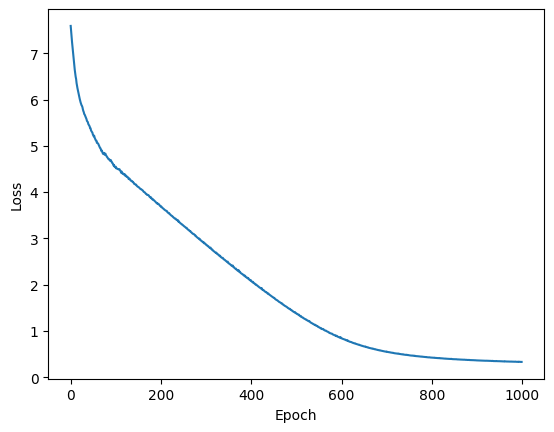

In [249]:
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [252]:
preds = model(inputs)
preds

tensor([[0.57286],
        [0.67915],
        [0.90261],
        [0.15694],
        [0.87609],
        [0.57286],
        [0.67915],
        [0.90261],
        [0.15694],
        [0.87609],
        [0.57286],
        [0.67915],
        [0.90261],
        [0.15694],
        [0.87609]], grad_fn=<SigmoidBackward0>)

In [254]:
y_pred_cls = (preds >= 0.5).to(torch.int64).squeeze(1)   # 0/1
y_pred_cls

tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

In [253]:
targets

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])

Модель в цілому натренувалась непогано. Бачимо зменшення помилки активно відбувається до 1000 епохи. Є вирогідність, що зі збільшенням епох помилка все ще продовжувала би зменшуватись, хоч і не так активно.  
Модель вірно визначила всі екземпляри класу 0, а от на класі 1 допустила 3 помилки. При цьому пробабілітіс в усіх 3 випадках складають 0.57286, тобто модель саме на цих екземплярах не дуже впевнена. Зменшивши поріг, можемо досягти 100% попадання по всіх екземплярах.